<h1>Objective :</h1>
<h3>The goal is to predict whether a food delivery will be "Fast" or "Delayed" based on features like customer location, restaurant location, weather, traffic conditions, and more. This dataset can be used to explore clustering and neural network models for predictive analytics.</h3>

<h1>Phase 1<br>Data Preprocessing</h1>(2 steps)

<h3>Step 1 - Data Import and Cleaning</h3>

In [381]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [382]:
data=pd.read_csv('Food_Delivery_Time_prediction.csv')
d=data.copy()
d.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [383]:
d.isnull().sum()

Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64

Null values do not exist in any column<br>
Now checking for incorrect data

In [384]:
#drop duplicate and empty rows of Order_ID column
d.dropna(subset=['Order_ID'])
d.drop_duplicates(subset='Order_ID', keep='first')
# drop incorrect data for Order_ID column
d.drop(d[ d['Order_ID'].str.match(r'^ORD\d{4}$')==False ].index, inplace=True) 
# here if inplace=True not used then the changes will not be applied to the original dataframe 

#drop rows with null values in Customer_Location column
d.dropna(subset=['Customer_Location'], inplace=True)

#drop rows with null values in Restaurant_Location column
d.dropna(subset=['Restaurant_Location'], inplace=True)

# # distance values all greater than 0
# d.loc[d['Distance']<=0,'Distance']=np.mean(d[d['Distance']>0]['Distance'])

# fill null values in Weather_Conditions with 'Sunny'
# Weather_Conditions values should be one of the following
d['Weather_Conditions'].fillna('Sunny')
valid_weather_conditions = ['Sunny', 'Rainy', 'Snowy', 'Cloudy']
d.loc[~d['Weather_Conditions'].isin(valid_weather_conditions), 'Weather_Conditions'] = 'Sunny'

# fill null values in Traffic_Conditions with 'Medium'
# Traffic_Conditions values should be one of the following
d['Traffic_Conditions'].fillna('Medium')
valid_traffic_conditions = ['Low', 'Medium', 'High']
d.loc[~d['Traffic_Conditions'].isin(valid_traffic_conditions), 'Traffic_Condisions'] = 'Medium'

# # Deliver_Person_Experience values should be positive and non-zero
# d.loc[d['Delivery_Person_Experience']<=0,'Delivery_Person_Experience']=np.mean(d.loc[d['Delivery_Person_Experience']>0,'Delivery_Person_Experience'])

# fill null values in Order_Priority with 'Medium'
# Order_Priority values should be one of the following
d['Order_Priority'].fillna('Medium')
valid_order_priority = ['Low', 'Medium', 'High']
d.loc[~d['Order_Priority'].isin(valid_order_priority), 'Order_Priority'] = 'Medium'

# fill null values in Order_Time with 'Night'
# Order_Time values should be one of the following
d['Order_Time'].fillna('Night')
valid_order_time = ['Afternoon', 'Night', 'Evening', 'Morning']
d.loc[~d['Order_Time'].isin(valid_order_time), 'Order_Time'] = 'Night'

# fill null values in Vehicle_Type with 'Bike'
# Vehicle_Type values should be one of the following
d['Vehicle_Type'].fillna('Bike')
valid_vehicle_type = ['Car', 'Bike', 'Bicycle']
d.loc[~d['Vehicle_Type'].isin(valid_vehicle_type), 'Vehicle_Type'] = 'Bike'


In [385]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54,NaN
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02,NaN
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17,NaN
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23,NaN
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,Cloudy,High,8,Medium,Night,Bike,4.7,4.0,50.39,1432.26,66.34,NaN
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,Snowy,Medium,8,Low,Night,Bicycle,3.0,3.6,90.54,1720.25,40.27,NaN
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,Snowy,High,4,Medium,Afternoon,Bike,2.9,3.4,73.20,1356.58,5.10,NaN
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,Rainy,High,9,Low,Night,Car,3.9,4.8,53.94,354.39,85.25,NaN


In [386]:
# Setting numeric values to column Weather_Conditions
weather_map = {'Sunny': 0, 'Rainy': 1, 'Snowy': 2, 'Cloudy': 3}
d['Weather_Conditions'] = d['Weather_Conditions'].map(weather_map)

# Setting numeric values to column Traffic_Conditions
traffic_map = {'Low': 0, 'Medium': 1, 'High': 2}
d['Traffic_Conditions'] = d['Traffic_Conditions'].map(traffic_map)

# Setting numeric values to column Vehicle_Type
vehicle_type_map = {'Bicycle': 0, 'Bike': 1, 'Car': 2}
d['Vehicle_Type'] = d['Vehicle_Type'].map(vehicle_type_map)

In [387]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,1,4,Medium,Afternoon,2,4.1,3.0,26.22,1321.10,81.54,NaN
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,3,1,8,Low,Night,2,4.5,4.2,62.61,152.21,29.02,NaN
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,1,9,High,Night,1,3.3,3.4,48.43,1644.38,64.17,NaN
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,3,0,2,Medium,Evening,1,3.2,3.7,111.63,541.25,79.23,NaN
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,2,6,Low,Night,1,3.5,2.8,32.38,619.81,2.34,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,3,2,8,Medium,Night,1,4.7,4.0,50.39,1432.26,66.34,NaN
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,2,1,8,Low,Night,0,3.0,3.6,90.54,1720.25,40.27,NaN
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,2,2,4,Medium,Afternoon,1,2.9,3.4,73.20,1356.58,5.10,NaN
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,1,2,9,Low,Night,2,3.9,4.8,53.94,354.39,85.25,NaN


In [388]:
# Standardization
s=StandardScaler()
d['Distance_Scaled'] = s.fit_transform(d[['Distance']])
d['Delivery_Time_Scaled'] = s.fit_transform(d[['Delivery_Time']])
# StandardScaler().fit_transform() expects a 2D array or DataFrame, but you passed a Series (d['Distance']), which is 1D.
# So pass a DataFrame with double brackets d[['Distance']]

In [389]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions,Distance_Scaled,Delivery_Time_Scaled
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,1,4,Medium,Afternoon,2,4.1,3.0,26.22,1321.10,81.54,NaN,-1.454738,-1.487932
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,3,1,8,Low,Night,2,4.5,4.2,62.61,152.21,29.02,NaN,1.439192,-0.264987
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,1,9,High,Night,1,3.3,3.4,48.43,1644.38,64.17,NaN,-0.666417,-0.741529
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,3,0,2,Medium,Evening,1,3.2,3.7,111.63,541.25,79.23,NaN,0.335835,1.382411
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,2,6,Low,Night,1,3.5,2.8,32.38,619.81,2.34,NaN,-0.700119,-1.280915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,3,2,8,Medium,Night,1,4.7,4.0,50.39,1432.26,66.34,NaN,1.805512,-0.675660
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,2,1,8,Low,Night,0,3.0,3.6,90.54,1720.25,40.27,NaN,-0.792431,0.673647
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,2,2,4,Medium,Afternoon,1,2.9,3.4,73.20,1356.58,5.10,NaN,1.335157,0.090908
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,1,2,9,Low,Night,2,3.9,4.8,53.94,354.39,85.25,NaN,1.840679,-0.556356


<h3>Step 2 - Feature Engineering</h3>

In [390]:
def haversine_formula(coords_array1, coords_array2):
    lat1 = coords_array1[:,0]
    lon1 = coords_array1[:,1]
    lat2 = coords_array2[:,0]
    lon2 = coords_array2[:,1]
    # Convert decimal degrees to radians 
    lat1=np.radians(lat1)
    lon1=np.radians(lon1)
    lat2=np.radians(lat2)
    lon2=np.radians(lon2)
    # Haversine formula 
    lat_diff = lat2 - lat1 
    lon_diff = lon2 - lon1 
    a = np.sin(lat_diff/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon_diff/2)**2
    c = 2 * np.asin(np.sqrt(a)) 
    r = 6371  # Radius of earth in km
    return c * r

def parse_location(loc_str):
    # Remove parentheses and split by comma
    lat, lon = loc_str.strip("()").split(",")
    return float(lat), float(lon)

coords_array1 = d['Customer_Location'].apply(parse_location).tolist()
coords_array1 = np.array(coords_array1)

coords_array2 = d['Restaurant_Location'].apply(parse_location).tolist()
coords_array2 = np.array(coords_array2)

d['Calculated_Distance'] = haversine_formula(coords_array1, coords_array2)

In [391]:
d[['Calculated_Distance']]

,Calculated_Distance
0,775.651198
1,1042.385597
2,476.220706
3,389.912629
4,806.505886
...,...
195,670.130652
196,558.891202
197,106.686689
198,880.580093


In [392]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions,Distance_Scaled,Delivery_Time_Scaled,Calculated_Distance
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,1,4,Medium,Afternoon,2,4.1,3.0,26.22,1321.10,81.54,NaN,-1.454738,-1.487932,775.651198
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,3,1,8,Low,Night,2,4.5,4.2,62.61,152.21,29.02,NaN,1.439192,-0.264987,1042.385597
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,1,9,High,Night,1,3.3,3.4,48.43,1644.38,64.17,NaN,-0.666417,-0.741529,476.220706
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,3,0,2,Medium,Evening,1,3.2,3.7,111.63,541.25,79.23,NaN,0.335835,1.382411,389.912629
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,2,6,Low,Night,1,3.5,2.8,32.38,619.81,2.34,NaN,-0.700119,-1.280915,806.505886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,3,2,8,Medium,Night,1,4.7,4.0,50.39,1432.26,66.34,NaN,1.805512,-0.675660,670.130652
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,2,1,8,Low,Night,0,3.0,3.6,90.54,1720.25,40.27,NaN,-0.792431,0.673647,558.891202
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,2,2,4,Medium,Afternoon,1,2.9,3.4,73.20,1356.58,5.10,NaN,1.335157,0.090908,106.686689
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,1,2,9,Low,Night,2,3.9,4.8,53.94,354.39,85.25,NaN,1.840679,-0.556356,880.580093


In [393]:
delivery_time_mean = np.mean(d['Delivery_Time'])
print(delivery_time_mean)

70.49494999999999


In [394]:
d['Delivery_Time_Binary'] = np.where(d['Delivery_Time'] > delivery_time_mean, 'rush hour', 'non-rush hour')
# 'rush hour' for delivery time greater than mean (Delayed), 'non-rush hour for less than or equal to mean(Fast)

In [395]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions,Distance_Scaled,Delivery_Time_Scaled,Calculated_Distance,Delivery_Time_Binary
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,1,4,Medium,Afternoon,2,4.1,3.0,26.22,1321.10,81.54,NaN,-1.454738,-1.487932,775.651198,non-rush hour
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,3,1,8,Low,Night,2,4.5,4.2,62.61,152.21,29.02,NaN,1.439192,-0.264987,1042.385597,non-rush hour
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,1,9,High,Night,1,3.3,3.4,48.43,1644.38,64.17,NaN,-0.666417,-0.741529,476.220706,non-rush hour
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,3,0,2,Medium,Evening,1,3.2,3.7,111.63,541.25,79.23,NaN,0.335835,1.382411,389.912629,rush hour
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,2,6,Low,Night,1,3.5,2.8,32.38,619.81,2.34,NaN,-0.700119,-1.280915,806.505886,non-rush hour
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,3,2,8,Medium,Night,1,4.7,4.0,50.39,1432.26,66.34,NaN,1.805512,-0.675660,670.130652,non-rush hour
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,2,1,8,Low,Night,0,3.0,3.6,90.54,1720.25,40.27,NaN,-0.792431,0.673647,558.891202,rush hour
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,2,2,4,Medium,Afternoon,1,2.9,3.4,73.20,1356.58,5.10,NaN,1.335157,0.090908,106.686689,rush hour
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,1,2,9,Low,Night,2,3.9,4.8,53.94,354.39,85.25,NaN,1.840679,-0.556356,880.580093,non-rush hour


<h1>Phase 2<br> Clustering using K-Means and Hierarchical Clustering</h1>(2 steps)

<h3>Step 3 - K Means Clustering</h3>

In [396]:
x=d[['Distance_Scaled', 'Weather_Conditions', 'Traffic_Conditions', 'Vehicle_Type', 'Delivery_Person_Experience']]
y=d['Delivery_Time_Binary']

In [397]:
x

,Distance_Scaled,Weather_Conditions,Traffic_Conditions,Vehicle_Type,Delivery_Person_Experience
0,-1.454738,1,1,2,4
1,1.439192,3,1,2,8
2,-0.666417,2,1,1,9
3,0.335835,3,0,1,2
4,-0.700119,1,2,1,6
...,...,...,...,...,...
195,1.805512,3,2,1,8
196,-0.792431,2,1,0,8
197,1.335157,2,2,1,4
198,1.840679,1,2,2,9


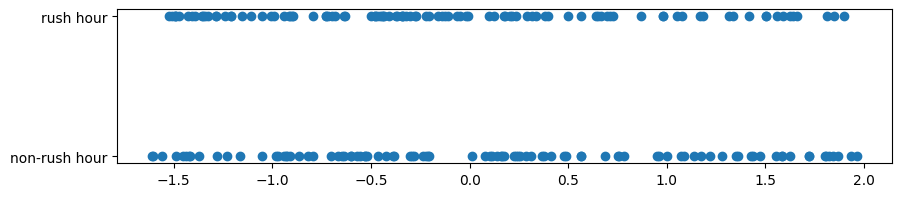

In [398]:
plt.figure(figsize=(10,2))
plt.scatter(x.iloc[:,0],y)
plt.show()

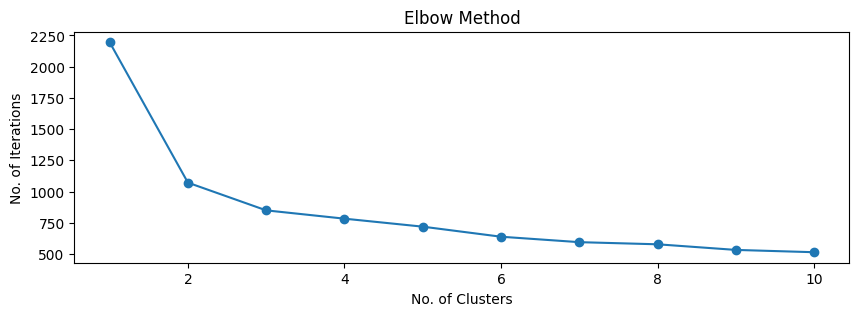

In [399]:
data = x.values
intertias = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data)
    intertias.append(kmeans.inertia_)

plt.figure(figsize=(10,3))
plt.plot(range(1, 11), intertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('No. of Iterations')
plt.show()


Here Elbow is being formed at k=2

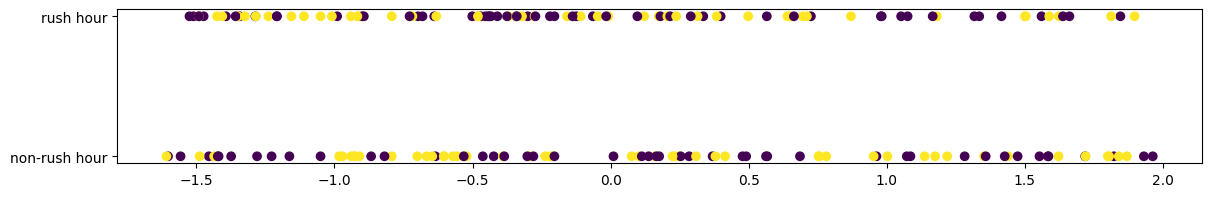

In [400]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.figure(figsize=(14,2))
plt.scatter(x.iloc[:,0],y,c=kmeans.labels_)
plt.show()

In [401]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(x.values)

x['Cluster'] = clusters

C:\Users\Princy Pandya\AppData\Local\Temp\ipykernel_2424\1306289772.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Cluster'] = clusters


In [402]:
x

,Distance_Scaled,Weather_Conditions,Traffic_Conditions,Vehicle_Type,Delivery_Person_Experience,Cluster
0,-1.454738,1,1,2,4,0
1,1.439192,3,1,2,8,2
2,-0.666417,2,1,1,9,2
3,0.335835,3,0,1,2,1
4,-0.700119,1,2,1,6,0
...,...,...,...,...,...,...
195,1.805512,3,2,1,8,2
196,-0.792431,2,1,0,8,2
197,1.335157,2,2,1,4,0
198,1.840679,1,2,2,9,2


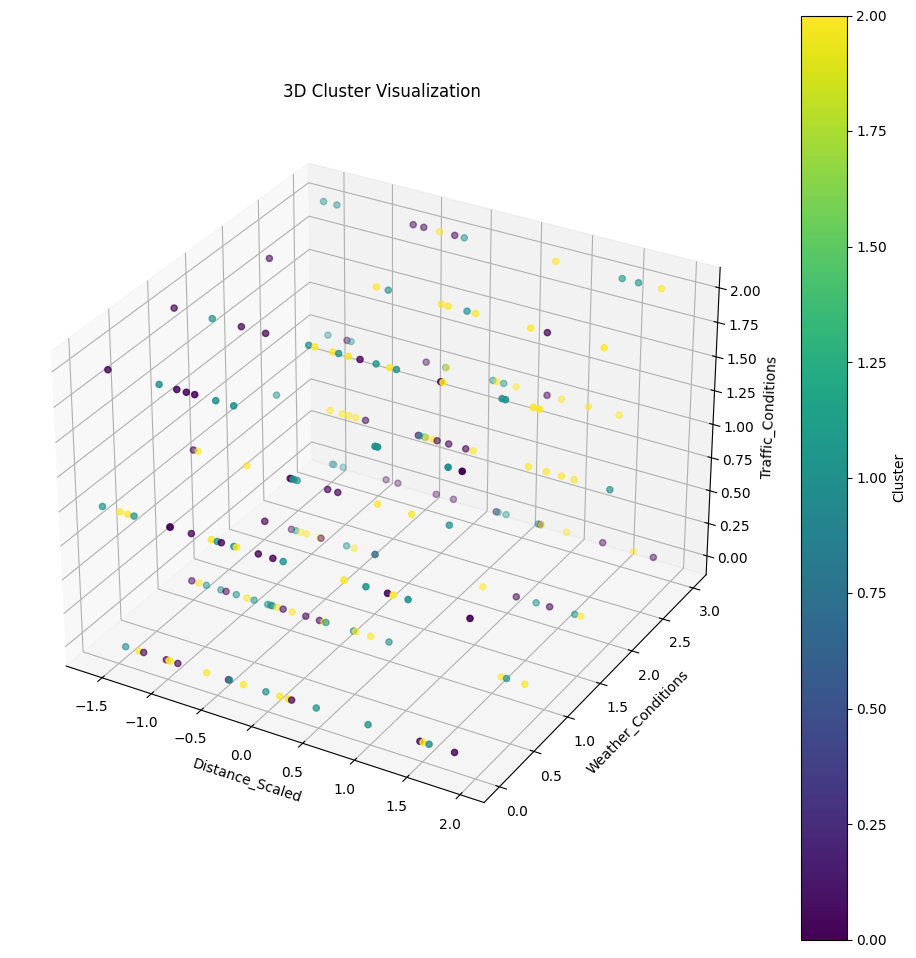

In [403]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    x['Distance_Scaled'],
    x['Weather_Conditions'],
    x['Traffic_Conditions'],
    c=x['Cluster'],
    cmap='viridis'
)

ax.set_xlabel('Distance_Scaled')
ax.set_ylabel('Weather_Conditions')
ax.set_zlabel('Traffic_Conditions')
plt.title('3D Cluster Visualization')
plt.colorbar(sc, label='Cluster')
plt.show()


In [404]:
cluster_analysis = pd.DataFrame({'Cluster': clusters, 'Delivery_Time_Binary': y})
print(cluster_analysis.groupby('Cluster')['Delivery_Time_Binary'].value_counts(normalize=True))


Cluster  Delivery_Time_Binary
0        rush hour               0.587302
         non-rush hour           0.412698
1        non-rush hour           0.514706
         rush hour               0.485294
2        non-rush hour           0.507246
         rush hour               0.492754
Name: proportion, dtype: float64


58.73% of deliveries of cluster 1 had rush hour<br>
41.26% of deliveries of cluster 1 had non-rush hour<br> AND SO ON.. FOR ALL OTHER CLUSTERS

<h3>Step 4 - Hierarchical Clustering</h3>

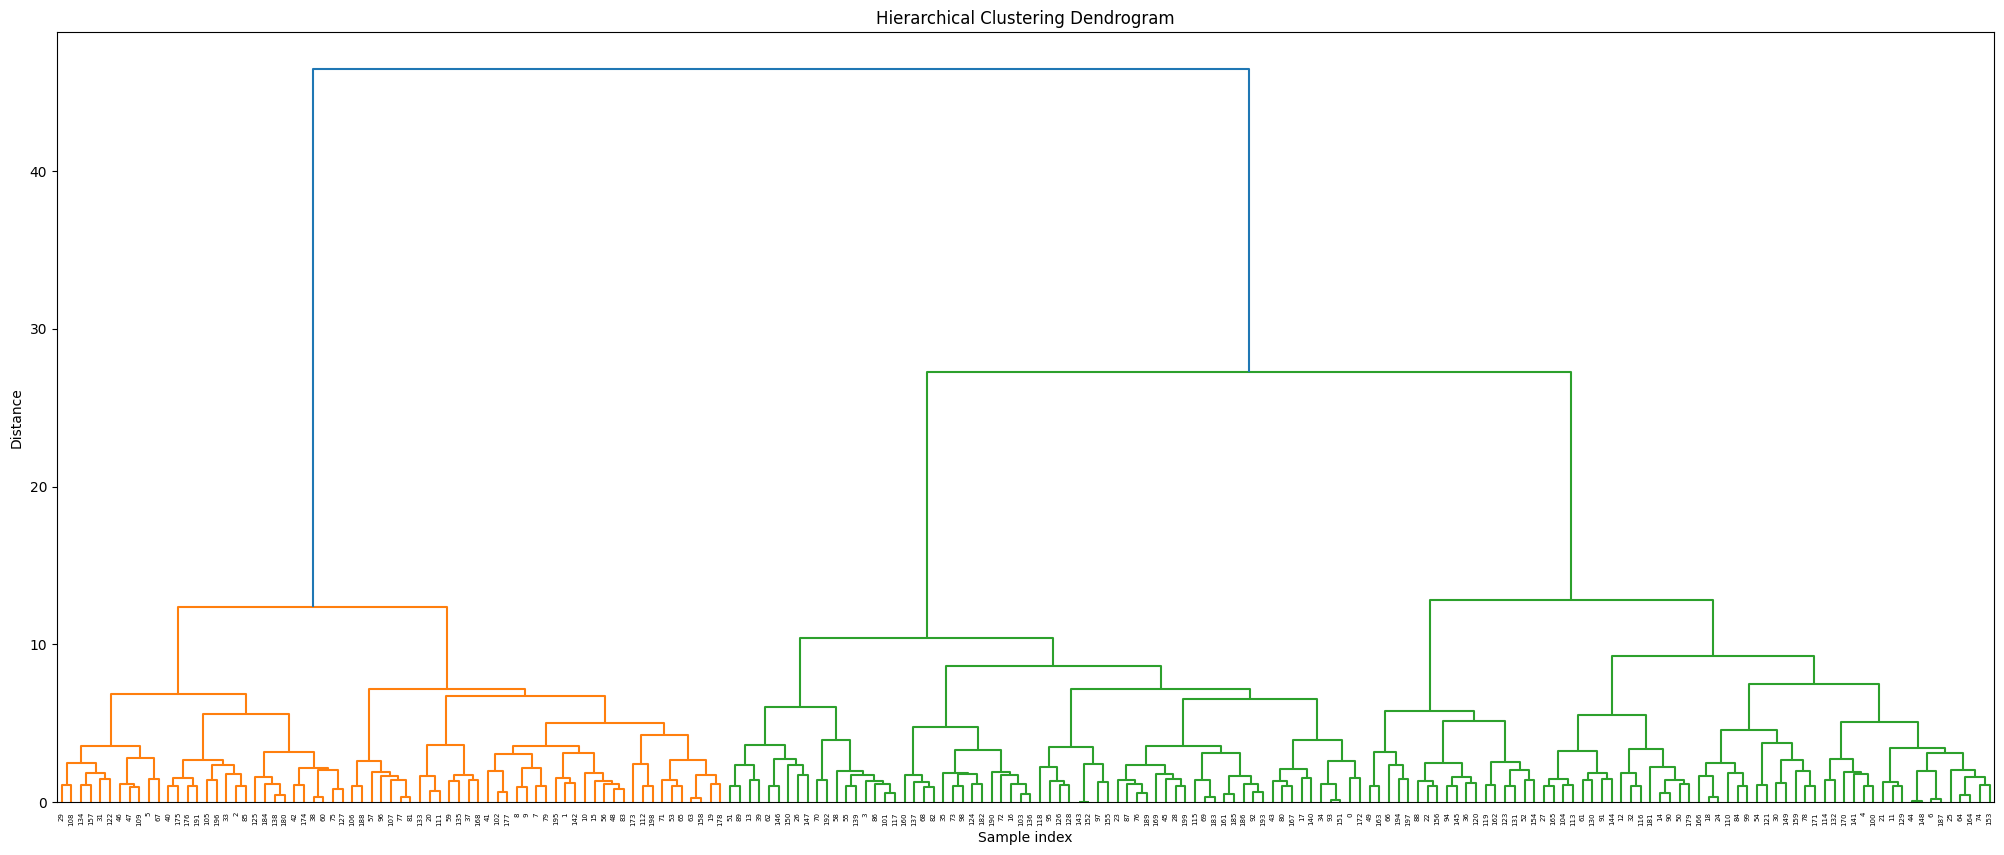

In [405]:
data = x.values

linkage_data = linkage(data, method='ward', metric='euclidean')

plt.figure(figsize=(25,10))
dendrogram(linkage_data)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

From this dendogram we can see that there are 3 colors so we have 2 clusters

In [406]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(data)

# Add cluster labels to DataFrame
x['Hier_Cluster'] = labels


C:\Users\Princy Pandya\AppData\Local\Temp\ipykernel_2424\369187969.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Hier_Cluster'] = labels


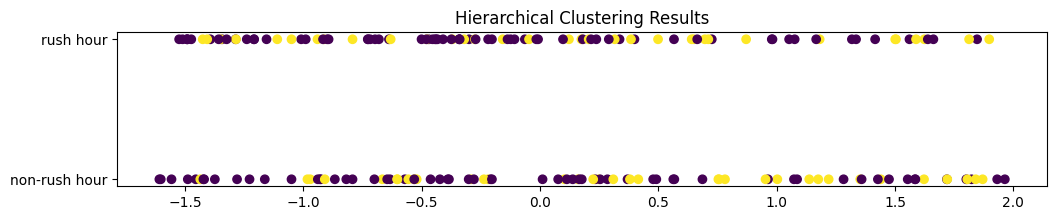

In [407]:
plt.figure(figsize=(12,2))
plt.scatter(x.iloc[:,0], y, c=labels)
plt.title('Hierarchical Clustering Results')
plt.show()

In [410]:
cluster_analysis = pd.DataFrame({'Hier_Cluster': clusters, 'Delivery_Time_Binary': y})
print(cluster_analysis.groupby('Hier_Cluster')['Delivery_Time_Binary'].value_counts(normalize=True))


Hier_Cluster  Delivery_Time_Binary
0             rush hour               0.587302
              non-rush hour           0.412698
1             non-rush hour           0.514706
              rush hour               0.485294
2             non-rush hour           0.507246
              rush hour               0.492754
Name: proportion, dtype: float64


<h3>Comparison</h3>

In [411]:
comparison = print(cluster_analysis.groupby('Hier_Cluster')['Delivery_Time_Binary'].value_counts(normalize=True))
print(comparison)

Hier_Cluster  Delivery_Time_Binary
0             rush hour               0.587302
              non-rush hour           0.412698
1             non-rush hour           0.514706
              rush hour               0.485294
2             non-rush hour           0.507246
              rush hour               0.492754
Name: proportion, dtype: float64
None


In [412]:
cluster_analysis = pd.DataFrame({
    'KMeans_Cluster': x['Cluster'],
    'Hier_Cluster': x['Hier_Cluster'],
    'Delivery_Time_Binary': y
})

# K-Means
print(cluster_analysis.groupby('KMeans_Cluster')['Delivery_Time_Binary'].value_counts(normalize=True))

print('\n\n')

# Agglomerative
print(cluster_analysis.groupby('Hier_Cluster')['Delivery_Time_Binary'].value_counts(normalize=True))


KMeans_Cluster  Delivery_Time_Binary
0               rush hour               0.587302
                non-rush hour           0.412698
1               non-rush hour           0.514706
                rush hour               0.485294
2               non-rush hour           0.507246
                rush hour               0.492754
Name: proportion, dtype: float64



Hier_Cluster  Delivery_Time_Binary
0             rush hour               0.534351
              non-rush hour           0.465649
1             non-rush hour           0.507246
              rush hour               0.492754
Name: proportion, dtype: float64


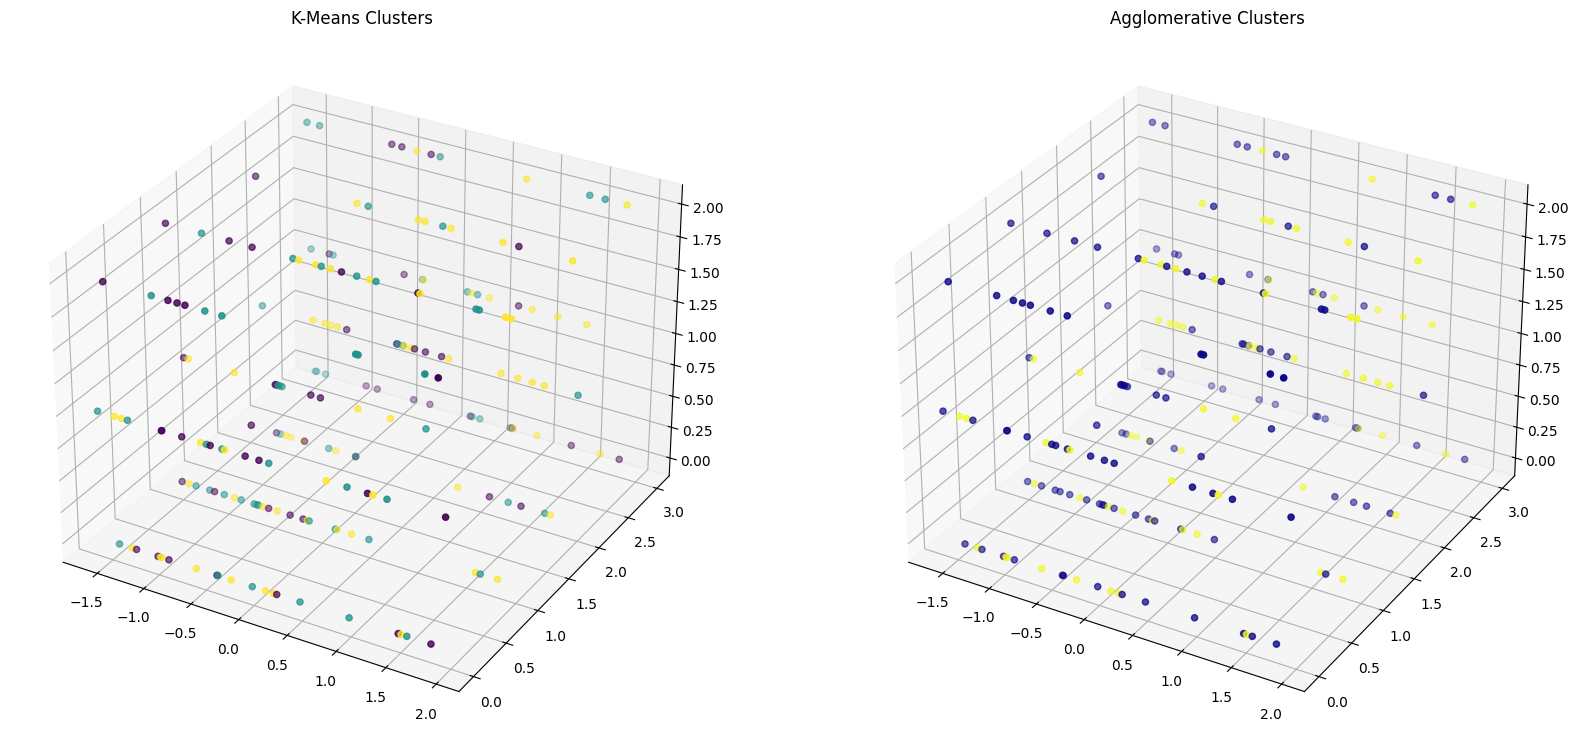

In [415]:
fig = plt.figure(figsize=(20,10))

# K-Means
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(
    x['Distance_Scaled'], x['Weather_Conditions'], x['Traffic_Conditions'],
    c=x['Cluster'], cmap='viridis'
)
ax1.set_title('K-Means Clusters')

# Agglomerative
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(
    x['Distance_Scaled'], x['Weather_Conditions'], x['Traffic_Conditions'],
    c=x['Hier_Cluster'], cmap='plasma'
)
ax2.set_title('Agglomerative Clusters')

plt.show()


<h1>Phase 3<br>Neural Networks for Prediction</h1>
(2 steps)

<h3>Step 5 - Introduction to Neural Networks</h3>

<h3>Step 7 - Actionable Insights</h3>

In [ ]:
insights = """
Strengths and Weaknesses:

- Gaussian Naive Bayes (GNB):
    Strengths: Simple, fast, and works well with small datasets. Easy to implement and interpret.
    Weaknesses: Assumes feature independence and Gaussian distribution, which may not hold for this dataset. Lower accuracy (0.40) and F1 score (0.45) indicate underperformance.

- K-Nearest Neighbors (KNN):
    Strengths: Non-parametric, can capture complex relationships, and performs reasonably well (accuracy: 0.48, F1: 0.59). No strong assumptions about data distribution.
    Weaknesses: Sensitive to feature scaling, less interpretable, and computationally expensive for large datasets.

- Decision Tree (DT):
    Strengths: Highest accuracy (0.53) and F1 score (0.60). Provides clear interpretability and can handle feature interactions. Pruning helps prevent overfitting.
    Weaknesses: Can overfit if not pruned, and performance may vary with small changes in data.

Recommendation:

Based on the results, the Decision Tree classifier is recommended for this task. It offers the best balance between predictive performance and interpretability, making it suitable for understanding the factors influencing delivery delays and for deployment in real-world scenarios.
"""

print(insights)



Strengths and Weaknesses:

- Gaussian Naive Bayes (GNB):
    Strengths: Simple, fast, and works well with small datasets. Easy to implement and interpret.
    Weaknesses: Assumes feature independence and Gaussian distribution, which may not hold for this dataset. Lower accuracy (0.40) and F1 score (0.45) indicate underperformance.

- K-Nearest Neighbors (KNN):
    Strengths: Non-parametric, can capture complex relationships, and performs reasonably well (accuracy: 0.48, F1: 0.59). No strong assumptions about data distribution.
    Weaknesses: Sensitive to feature scaling, less interpretable, and computationally expensive for large datasets.

- Decision Tree (DT):
    Strengths: Highest accuracy (0.53) and F1 score (0.60). Provides clear interpretability and can handle feature interactions. Pruning helps prevent overfitting.
    Weaknesses: Can overfit if not pruned, and performance may vary with small changes in data.

Recommendation:

Based on the results, the Decision Tree classifie

### Final Summary

This project focused on classifying food delivery status as either *“Fast”* or *“Delayed”* using factors such as order timing, distance, traffic conditions, and delivery experience. The pipeline included data cleaning, encoding categorical features, feature scaling, and applying classification models to predict delivery performance.

- *Data Preparation:* The dataset was cleaned and transformed by handling missing values, encoding categorical variables, scaling distance metrics, and mapping delivery outcomes to binary labels (*Fast = 0*, *Delayed = 1*).

- *Model Evaluation:*
  - **Gaussian Naive Bayes (GNB)** achieved low performance with an *accuracy of 40%* and *F1-score of 45%*, due to its strong assumptions about feature independence and normal distribution.
  - **K-Nearest Neighbors (KNN)** improved performance to an *accuracy of 48%* and *F1-score of 59%*, capturing non-linear patterns but being sensitive to feature scaling.
  - **Decision Tree (DT)** delivered the highest *accuracy of 53%* and *F1-score of 60%*, offering strong interpretability and benefiting from hyperparameter tuning (pruning) to control overfitting.

- *Insights & Recommendations:*
  - Most features showed weak individual correlation with delivery status, indicating that delivery delays are influenced by complex interactions or unrecorded external factors.
  - Simpler models offer limited predictive power; however, Decision Trees provide actionable insights due to their explainability.

In conclusion, the Decision Tree model is the most suitable for this task, balancing interpretability and predictive performance. For better accuracy in real-world applications, future work should incorporate additional real-time variables like GPS route data, live traffic conditions, and driver behavior patterns. Furthermore, ensemble methods such as Random Forest or Gradient Boosting could be explored to improve prediction quality.
